### Import libraries

In [1]:
# import all libraries
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import *
import uuid
import tensorflow as tf
from keras.metrics import Precision, Recall
import keras

In [11]:
# define hyperparameters
BATCH_SIZE = 16
EPOCHS = 100
POSITIVE_PATH = os.path.join("data", "positive")
NEGATIVE_PATH = os.path.join("data", "negative")
ANCHOR_PATH = os.path.join("data", "anchor")

# Dataset  

### 1. Load images

In [12]:
# get images 
anchor_images = tf.data.Dataset.list_files(ANCHOR_PATH + "\*jpg").take(3000)
positive_images = tf.data.Dataset.list_files(POSITIVE_PATH + "\*jpg").take(3000)
negative_images = tf.data.Dataset.list_files(NEGATIVE_PATH + "\*jpg").take(3000)

In [13]:
# see number of each class images
print(f"Number of anchor image: {len(anchor_images)}")
print(f"Number of positive images: {len(positive_images)}")
print(f"Number of negative images: {len(negative_images)}")

Number of anchor image: 746
Number of positive images: 3000
Number of negative images: 3000


### 2. Create preprocessing functions

In [14]:
def preprocess_image(file_path):
    """
    This function will decode and resize images 
    Then it will resize the images between 1 and 0
    """
    byte_image = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(byte_image)
    image = tf.image.resize(image, (100, 100))
    image = image / 255.

    return image

In [15]:
def preprocess(input_img, verification_img, label):
    """
    Apply preprocessing to images using preprocess_image function
    """
    input_preprocess = preprocess_image(input_img)
    verification_preprocess = preprocess_image(verification_img)

    return input_preprocess, verification_preprocess, label

### 3. Create labeled dataset 

In [16]:
# create the data
positives = tf.data.Dataset.zip((anchor_images, positive_images, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor_images)))))
negatives = tf.data.Dataset.zip((anchor_images, negative_images, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor_images)))))
dataset = positives.concatenate(negatives)

In [17]:
# build the data loader 
dataset = dataset.map(preprocess)
dataset = dataset.cache()
dataset = dataset.shuffle(10000)

### 4. Split the data

In [18]:
# train partition
train_dataset = dataset.take(round(len(dataset) * 0.8))
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(8)

In [19]:
# test partition 
test_dataset = dataset.skip(round(len(dataset) * 0.8))
test_dataset = dataset.take(round(len(dataset) * 0.2))
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(8)

# Neural Networks

### 1. Make embedding

In [4]:
def make_embedding():
    """
    This function will create the embedding
    """
    # input layer (shape: (100, 100, 3))
    input_layer = Input(shape=(100, 100, 3), name="input_image")

    # Conv block 1
    c1 = Conv2D(64, (10,10), activation='relu')(input_layer)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Conv block 2
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Conv block 3
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Finnal embeding block
    c4 = Conv2D(256, kernel_size=(4, 4), activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)

    # define the final embedding
    embedding = Model(inputs=[input_layer], outputs=[d1], name="embedding")

    return embedding

In [5]:
# defien the embedding and see it summary
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

### 2. Distance layer

In [6]:
class DistanceLayer(Layer):
    """
    Calculate the distance between between anchor image, Positive / Negative
    Somehow compare the input image and the VERIFICATION image 
    """
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, verification_embedding):
        distance = tf.math.abs(input_embedding - verification_embedding)

        return distance

### 3. Make the final Siamese network 

In [40]:
def make_siamese():
    """
    Create siamese network 
    """
    # get the verification and input images
    input_image = Input(name="input_image", shape=(100, 100, 3))
    verification_image = Input(name="verification_input", shape=(100, 100, 3))

    # put both inputs into embeddings
    input_embedding = embedding(input_image)
    verification_embedding = embedding(verification_image)

    # distance layer
    distance_layer = DistanceLayer()
    distance_layer._name = "distance_layer"
    distance = distance_layer(input_embedding, verification_embedding)

    # final classifier 
    classifier = Dense(1, activation="sigmoid", name="classifier")(distance)

    # final model
    siamese_net = Model(inputs=[input_image, verification_image], outputs=classifier, name="siamese_network")

    return siamese_net

In [41]:
# define the siamese model
siamese_network = make_siamese()
siamese_network.summary()

Model: "siamese_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 verification_input (InputLayer  [(None, 100, 100, 3  0          []                               
 )                              )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'verification_inpu

### 4. Train the model

In [42]:
# setup loss and optimizer
loss_function = tf.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(1e-4)

In [43]:
@tf.function
def train_step(batch):
    """
    Containes a train step of hole training operation
    """
    with tf.GradientTape() as tape:
        # get anchor, positive and negative
        X = batch[:2]
        y = batch[2]

        # forward pass
        y_hat = siamese_network(X, training=True)
        loss = loss_function(y, y_hat)

    print(loss)

    # gradient and optimizer
    gradient = tape.gradient(loss, siamese_network.trainable_variables)
    optimizer.apply_gradients(zip(gradient, siamese_network.trainable_variables))

    return loss

In [44]:
def train(data, num_epochs):
    """
    This function will train the model
    """
    for epoch in range(num_epochs):
        print(f"\n Epoch: {epoch+1}/{num_epochs}")

        # define recall and precision
        recall = Recall()
        precision = Precision()

        for idx, batch in enumerate(data):
            # run a train step
            loss = train_step(batch)
            y_hat = siamese_network.predict(batch[:2])
            recall.update_state(batch[2], y_hat)
            precision.update_state(batch[2], y_hat)

        print(loss.numpy() , recall.result().numpy(), precision.result().numpy())

In [45]:
# train the model
train(train_dataset, EPOCHS)


 Epoch: 1/100
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
1/1 [==============================] - 0s 200ms/step
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
1/1 [==============================] - 0s 126ms/step
0.027231995 0.9916805 0.97865355

 Epoch: 2/100
1/1 [==============================] - 0s 119ms/step
0.0019697186 0.9931507 0.99827886

 Epoch: 3/100
1/1 [==============================] - 0s 127ms/step
7.168655e-05 0.99834985 0.99834985

 Epoch: 4/100
1/1 [==============================] - 0s 126ms/step
6.771998e-05 0.99833333 1.0

 Epoch: 5/100
1/1 [==============================] - 0s 121ms/step
0.00016289993 1.0 1.0

 Epoch: 6/100
1/1 [==============================] - 0s 128ms/step
1.2022672e-05 1.0 1.0

 Epoch: 7/100
1/1 [==============================] - 0s 129ms/step
3.5342404e-05 1.0 1.0

 Epoch: 8/100
1/1 [========================

In [46]:
# save the trained model
siamese_network.save('face_id_model.h5')

### 5. Test the model

In [7]:
# load model
model = load_model("face_id_model.h5", custom_objects={"DistanceLayer":DistanceLayer, "BinaryCrossentropy":tf.losses.BinaryCrossentropy})

In [8]:
# define recall and precision
recall = Recall()
precision = Precision()

In [20]:
# make model to do predictions
for test_input, test_val, y_true in test_dataset.as_numpy_iterator():
    y_hat = model.predict([test_input, test_val])
    recall.update_state(y_true, y_hat)
    precision.update_state(y_true, y_hat)
# print results
print(recall.result().numpy(), precision.result().numpy())
print(y_true)

1/1 [==============================] - 2s 2s/step
1.0 1.0
[0. 1. 1. 0. 1. 1. 0. 0. 1. 0.]


0 is False <br>
1 is True

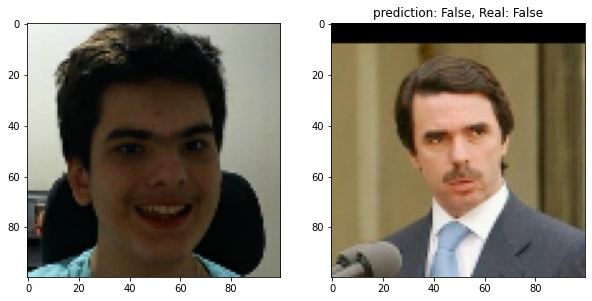

In [53]:
# render results
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[9])
plt.subplot(1,2,2)
plt.imshow(test_val[9])
plt.title("prediction: False, Real: False")
plt.show()

# Use the model

### 1. Collect data for verification

In [29]:
# define paths
input_path = os.path.join("app_data", "input_images")
verification_path = os.path.join("app_data", "verification_images")

In [38]:
# get the webcam feed 
capture = cv2.VideoCapture(1)

while capture.isOpened():
    ret, frame = capture.read()
    frame = frame[120:120+250,200:200+250, :]

    # collect validation images
    if cv2.waitKey(1) & 0xFF == ord("a"):
        image_name = os.path.join(verification_path, "ver{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(image_name, frame)

    cv2.imshow("Add face", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

capture.release()
cv2.destroyAllWindows()

### 2. Use and make predictions

In [48]:
def verify_face(model, detection_threshold, verification_threshold):
    """
    This function will verify the person's face
    """
    # build results array
    results = []
    for image in os.listdir(os.path.join('app_data', 'verification_images')):
        input_img = preprocess_image(os.path.join('app_data', 'input_images', 'input_image.jpg'))
        validation_img = preprocess_image(os.path.join('app_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('app_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [73]:
# get the webcam feed 
capture = cv2.VideoCapture(1)
verified = None
while capture.isOpened():
    ret, frame = capture.read()
    frame = frame[120:120+250,200:200+250, :]

    # make prediction
    if cv2.waitKey(1) & 0xFF == ord("v"):
        cv2.imwrite(os.path.join("app_data", "input_images", "input_image.jpg"), frame)
        results, verified = verify_face(model, 0.4, 0.4)
        print("Person Verified")

    cv2.imshow("Face ID", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

capture.release()
cv2.destroyAllWindows()

NameError: name 'new_frame' is not defined

In [74]:
capture.release()
cv2.destroyAllWindows()